In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display
import seaborn as sns

In [2]:
def min_max_norm(v):
    return (v - v.min()) / (v.max() - v.min())

In [3]:
# Segment each controlled trial run

fft = pd.read_csv('data/diego-controlled-runs/grafana_data_export oct_fftcb.csv', sep=';', engine='python', header=1)
fft['Time'] = pd.to_datetime(fft['Time'])
fft.reset_index(inplace=True, drop=True)

def get_run_code(data, start, end, condition, pressure, stiffener_kit, display=False):
    
    if display:
        figure(figsize=(20, 6), dpi=80)
        plt.scatter(x=data.iloc[start:end, :].index, 
                    y=data.iloc[start:end, :]['Value'], alpha=.7, s=5)
        plt.ylabel('FFT')
        plt.show()

    df = data.iloc[start:end, :].reset_index(drop=True)
    df['condition'] = condition
    df['pressure'] = pressure
    df['stiffener kit'] = stiffener_kit
    return df

CB_FFT_Band3_B1 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 1920, 2750, 'Target', 2.3, True)
CB_FFT_Band3_B2 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 3650, 4500, 'Low', 1.8, True)
CB_FFT_Band3_B3 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 6610, 7430, 'Ultra Low', 1.4, True)
CB_FFT_Band3_A1 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 23292, 23483, 'Target', 3.4, False)
CB_FFT_Band3_A2 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 24098, 24780, 'Low', 2.7, False)
CB_FFT_Band3_A3 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 24843, 25342, 'Low', 2.0, False)
CB_FFT_Band3_A4 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 25666, 26280, 'Target', 3.4, False)
CB_FFT_Band3_A5 = get_run_code(fft[fft['Series'] == 'CB FFT Band 3'].reset_index(drop=True), 26560, 26684, 'High', 4.0, False)

In [5]:
# Combine all trials into one DF
domingo_band3 = pd.concat([CB_FFT_Band3_B1, CB_FFT_Band3_B2, CB_FFT_Band3_B3,
                           CB_FFT_Band3_A1, CB_FFT_Band3_A2, CB_FFT_Band3_A3, CB_FFT_Band3_A4, CB_FFT_Band3_A5])
domingo_band3 = domingo_band3.rename(columns={'Value': 'FFT'})
domingo_band3 = domingo_band3.reset_index(drop=True)
domingo_band3
# domingo_band3.to_csv('data/reformated/diego-controlled-oct-fftcb-band3.csv')

Series                      Time       FFT condition  pressure  \
0     CB FFT Band 3 2021-06-21 09:25:30+02:00  0.402173    Target       2.3   
1     CB FFT Band 3 2021-06-21 09:25:30+02:00  0.434493    Target       2.3   
2     CB FFT Band 3 2021-06-21 09:25:30+02:00  0.437564    Target       2.3   
3     CB FFT Band 3 2021-06-21 09:25:30+02:00  0.265910    Target       2.3   
4     CB FFT Band 3 2021-06-21 09:25:30+02:00  0.347339    Target       2.3   
...             ...                       ...       ...       ...       ...   
4605  CB FFT Band 3 2021-06-21 16:36:50+02:00  0.195899      High       4.0   
4606  CB FFT Band 3 2021-06-21 16:36:50+02:00  0.209436      High       4.0   
4607  CB FFT Band 3 2021-06-21 16:36:50+02:00  0.205936      High       4.0   
4608  CB FFT Band 3 2021-06-21 16:36:50+02:00  0.190878      High       4.0   
4609  CB FFT Band 3 2021-06-21 16:36:50+02:00  0.156201      High       4.0   

      stiffener kit  
0              True  
1              True  
2              True  
3              True  
4              True  
...             ...  
4605          False  
4606          False  
4607          False  
4608          False  
4609          False  

[4610 rows x 6 columns]

Text(0, 0.5, 'FFT')

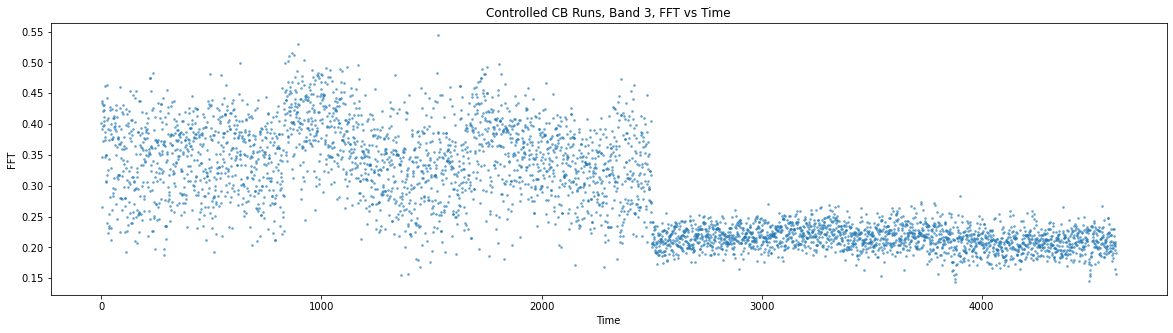

In [6]:
figure(figsize=(20,5))
plt.scatter(domingo_band3.index, domingo_band3['FFT'], s=3, alpha=.5)
plt.title('Controlled CB Runs, Band 3, FFT vs Time')
plt.xlabel('Time')
plt.ylabel('FFT')

In [15]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def silhouette_cluster_analysis(data, df, algorithm='hac'):
    range_n_clusters = np.arange(2,12)

    best_clustering = None
    best_sil_avg = 0

    for n_clusters in range_n_clusters:

        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

        if algorithm == 'kmeans':
            clustering = KMeans(n_clusters=n_clusters).fit( data )
        if algorithm == 'hac':
            clustering = AgglomerativeClustering(n_clusters=n_clusters).fit( data )
        labels = clustering.labels_
        df['Labels'] = labels

        silhouette_avg = silhouette_score(data, labels)

        if silhouette_avg > best_sil_avg:
            best_sil_avg = silhouette_avg
            best_clustering = clustering

        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(labels.astype(float) / n_clusters)
        ax2.scatter(
            df.index, df.FFT, marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # # Labeling the clusters
        # centers = clustering.cluster_centers_
        # # Draw white circles at cluster centers
        # ax2.scatter(
        #     centers[:, 0],
        #     centers[:, 1],
        #     marker="o",
        #     c="white",
        #     alpha=1,
        #     s=200,
        #     edgecolor="k",
        # )

        # for i, c in enumerate(centers):
        #     ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()
    return best_clustering

        FFT  pressure  stiffener kit  condition_High  condition_Low  \
0  0.402173       2.3              1               0              0   
1  0.434493       2.3              1               0              0   
2  0.437564       2.3              1               0              0   
3  0.265910       2.3              1               0              0   
4  0.347339       2.3              1               0              0   

   condition_Target  condition_Ultra Low  
0                 1                    0  
1                 1                    0  
2                 1                    0  
3                 1                    0  
4                 1                    0  
[[0.06713381 0.55921379 1.         ... 0.         1.         0.        ]
 [0.07551394 0.55921379 1.         ... 0.         1.         0.        ]
 [0.0763102  0.55921379 1.         ... 0.         1.         0.        ]
 ...
 [0.01625231 1.         0.         ... 0.         0.         0.        ]
 [0.01234798 1.   

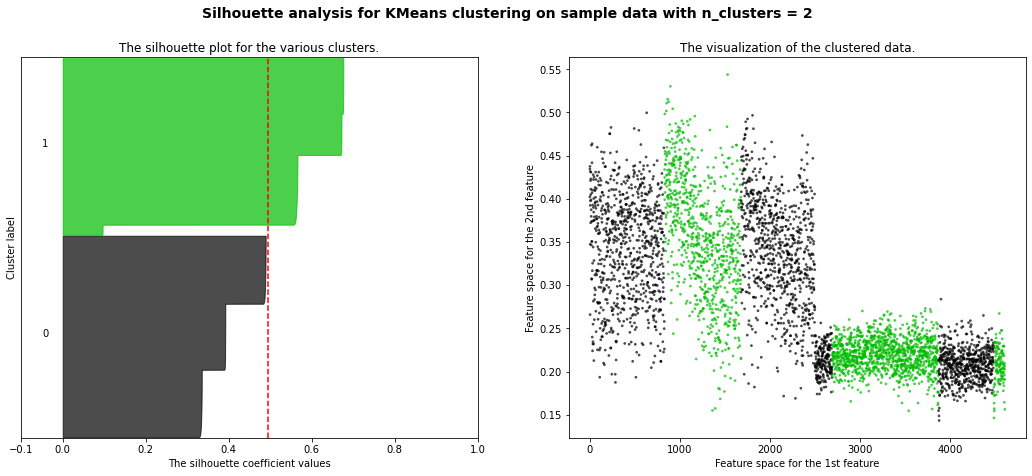

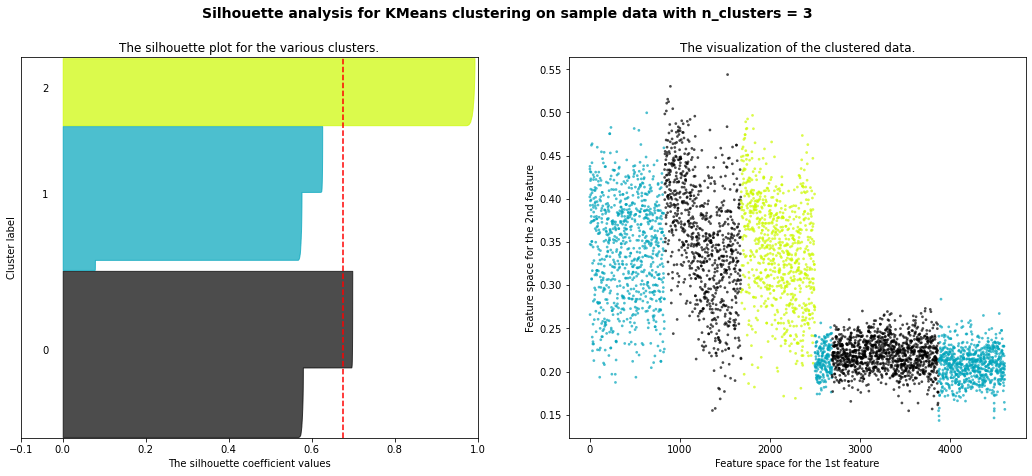

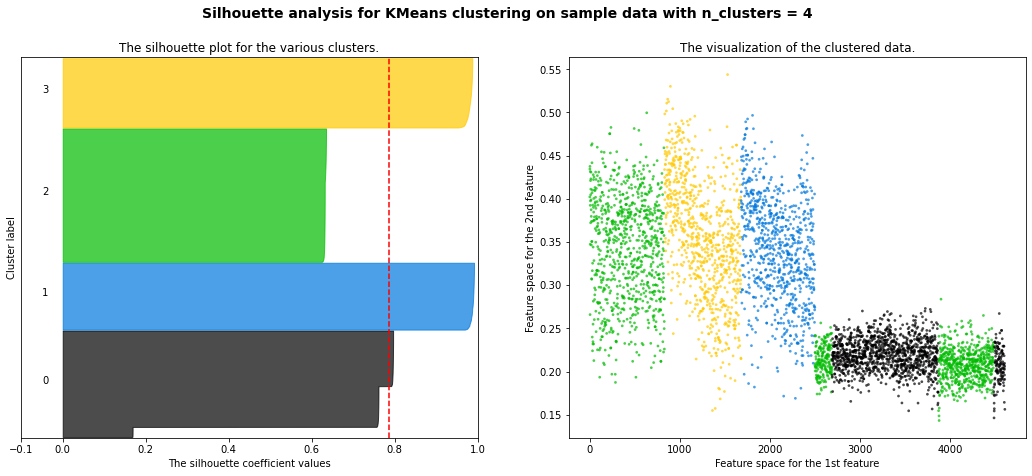

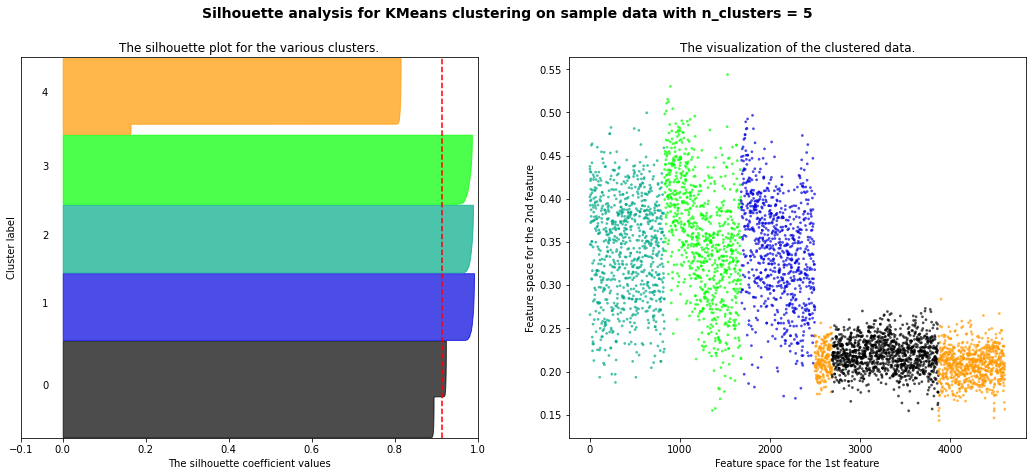

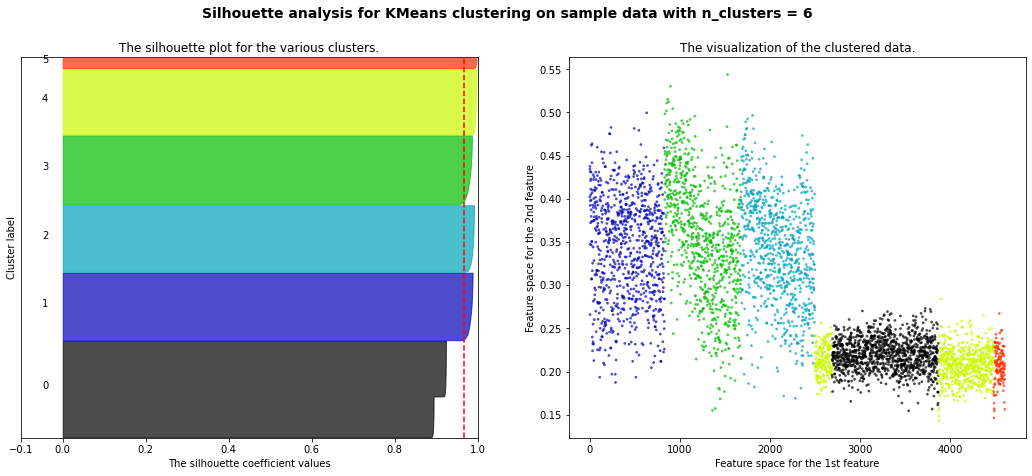

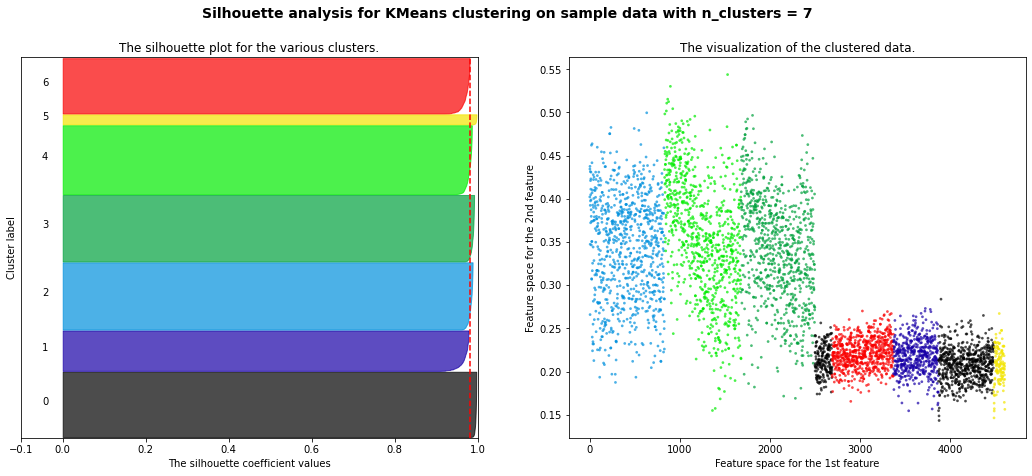

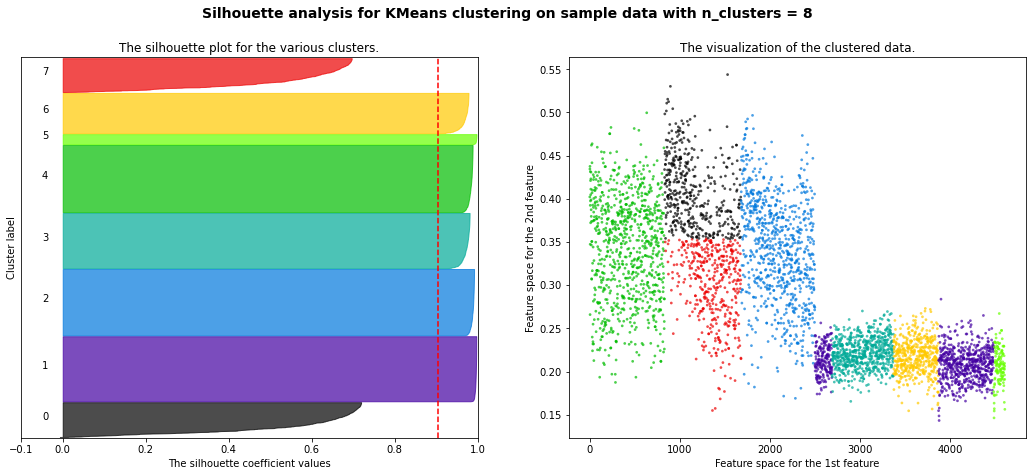

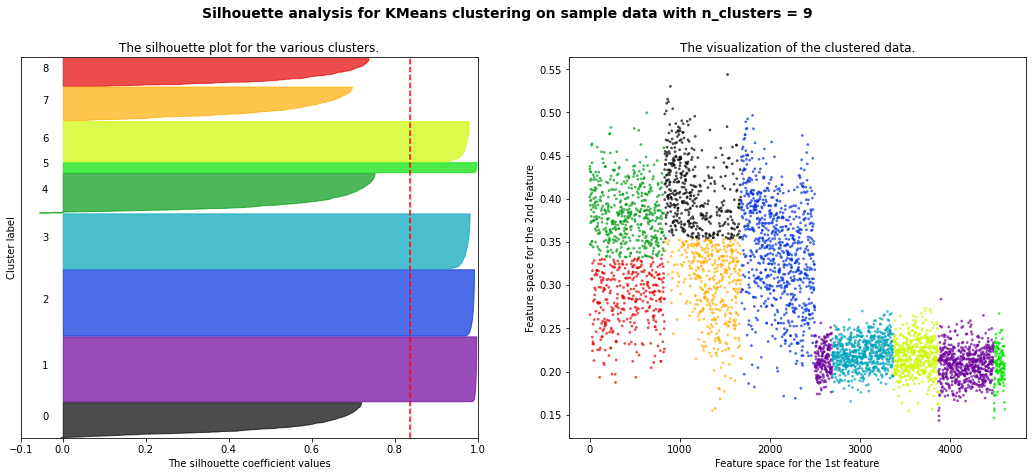

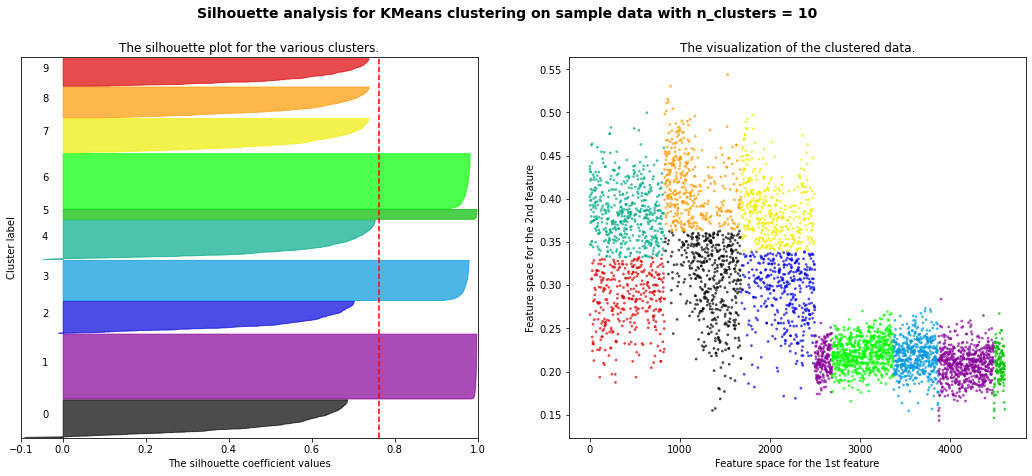

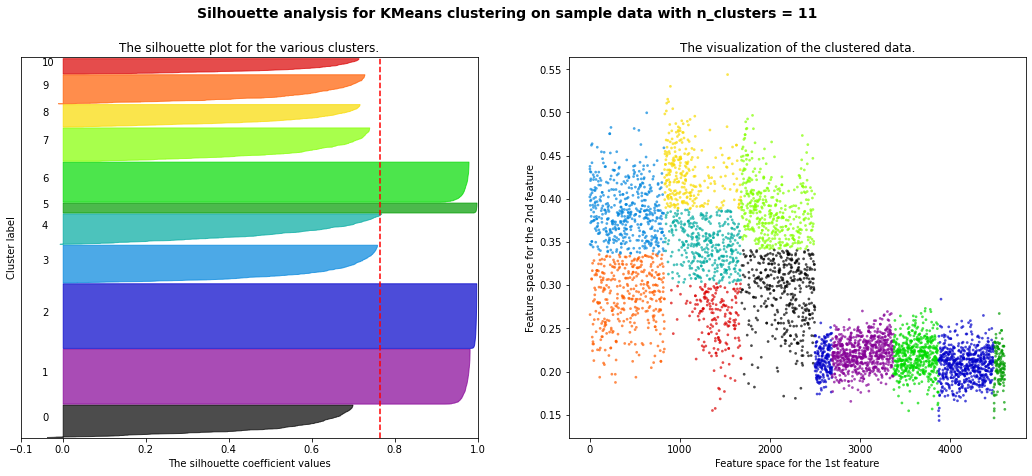

In [16]:
controlled_fft_cluster_df = domingo_band3.drop(columns=['Series', 'Time'])
# controlled_fft_cluster_df['condition'] = controlled_fft_cluster_df['condition'].map({'Ultra Low': 0,
#                                        'Low': 1,
#                                        'Target': 2,
#                                        'High': 3,
#                                        'Ultra High': 4})
controlled_fft_cluster_df = pd.get_dummies(controlled_fft_cluster_df)
controlled_fft_cluster_df['stiffener kit'] = controlled_fft_cluster_df['stiffener kit'].astype(int)
print(controlled_fft_cluster_df.head())

controlled_fft_pressures = np.array(controlled_fft_cluster_df.pressure)

controlled_fft_cluster_data = controlled_fft_cluster_df.to_numpy()

# Normalize FFT and Pressure
controlled_fft_cluster_data[:, :2] = min_max_norm(controlled_fft_cluster_data[:, :2])
print(controlled_fft_cluster_data)

# Perform clustering
controlled_fft_best_clustering = silhouette_cluster_analysis(controlled_fft_cluster_data, controlled_fft_cluster_df, 'kmeans')

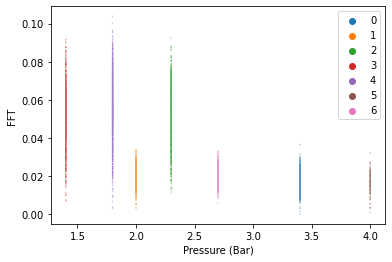

In [19]:
# FFT vs Pressure
sns.scatterplot(x=controlled_fft_pressures, y=controlled_fft_cluster_data[:, 0], s=2, alpha=.5,
                hue=controlled_fft_best_clustering.labels_, 
                palette=
                    sns.color_palette( n_colors=len(np.unique(controlled_fft_best_clustering.labels_))) )
plt.title('Band 3 FFT Clustering by Pressure')
plt.xlabel('Pressure (Bar)')
plt.ylabel('FFT')
plt.show()

FFT  pressure  stiffener kit  condition_High  condition_Low  \
0  0.402173       2.3              1               0              0   
1  0.434493       2.3              1               0              0   
2  0.437564       2.3              1               0              0   
3  0.265910       2.3              1               0              0   
4  0.347339       2.3              1               0              0   

   condition_Target  condition_Ultra Low  Labels  
0                 1                    0       3  
1                 1                    0       3  
2                 1                    0       3  
3                 1                    0       9  
4                 1                    0       3

Series                      Time       FFT condition  pressure  \
0  CB FFT Band 3 2021-06-21 09:25:30+02:00  0.402173    Target       2.3   
1  CB FFT Band 3 2021-06-21 09:25:30+02:00  0.434493    Target       2.3   
2  CB FFT Band 3 2021-06-21 09:25:30+02:00  0.437564    Target       2.3   
3  CB FFT Band 3 2021-06-21 09:25:30+02:00  0.265910    Target       2.3   
4  CB FFT Band 3 2021-06-21 09:25:30+02:00  0.347339    Target       2.3   

   stiffener kit  
0           True  
1           True  
2           True  
3           True  
4           True

[[0.06713381 0.55921379 1.         ... 0.         1.         0.        ]
 [0.07551394 0.55921379 1.         ... 0.         1.         0.        ]
 [0.0763102  0.55921379 1.         ... 0.         1.         0.        ]
 ...
 [0.01625231 1.         0.         ... 0.         0.         0.        ]
 [0.01234798 1.         0.         ... 0.         0.         0.        ]
 [0.00335672 1.         0.         ... 0.         0.         0.        ]]
[-0.0052345  -0.00581048 -0.00586521 ...  0.4380065   0.43827486
  0.43889284]
[0.99192063]


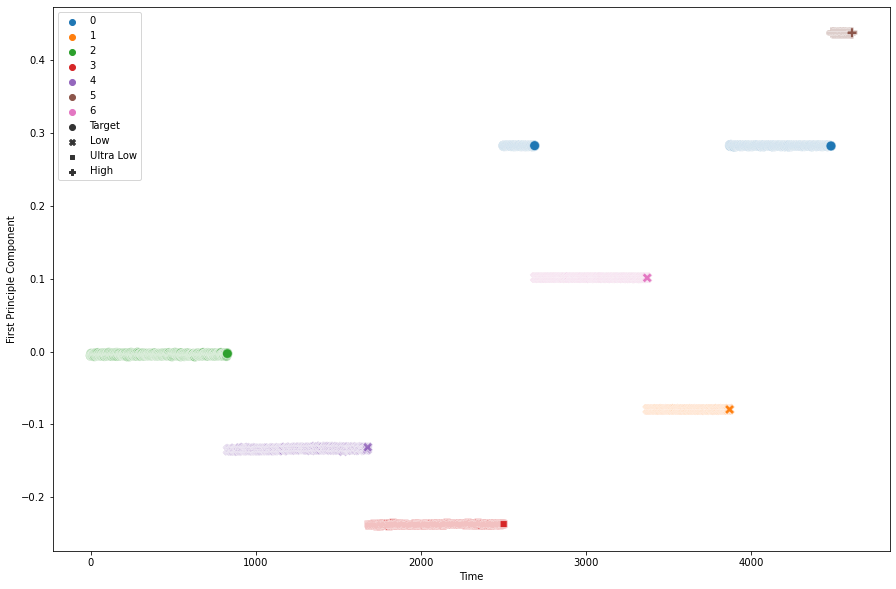

In [50]:
# PCA visualization
from sklearn.decomposition import PCA
display(controlled_fft_cluster_df.head())
display(domingo_band3.head())
print(controlled_fft_cluster_data)

pca = PCA(n_components=1)
first_pc = pca.fit_transform(controlled_fft_cluster_data[:, :2]).reshape(-1)
print(first_pc)
print(pca.explained_variance_ratio_)

figure(figsize=(15,10))
start, end = 0, len(first_pc)
sns.scatterplot(x=controlled_fft_cluster_df.index[start:end],
                y=first_pc[start:end],
                hue=controlled_fft_best_clustering.labels_[start:end],
                style=domingo_band3.condition.iloc[start:end],
                palette=sns.color_palette( n_colors=len(np.unique(controlled_fft_best_clustering.labels_[start:end]))),
                s=100, alpha=.5)
plt.title('Band 3 FFT clustering by first principle component')
plt.xlabel('Time')
plt.ylabel('First Principle Component')
plt.legend()

In [52]:
oct_overall = pd.read_csv('data/diego-controlled-runs/grafana_data_export oct_overall.csv', sep=';', engine='python', header=1)
oct_overall = oct_overall[oct_overall['Series'] == 'CB Bond Vibration'].reset_index(drop=True)
oct_overall_cb = oct_overall.drop(columns='Series')

CB_RMS_OVERALL_B1 = get_run_code(oct_overall_cb, 11700, 16700, 'Target', 2.3, True)
CB_RMS_OVERALL_B2 = get_run_code(oct_overall_cb, 23000, 28050, 'Low', 1.8, True)
CB_RMS_OVERALL_B3 = get_run_code(oct_overall_cb, 42790, 47700, 'Ultra Low', 1.4, True)
CB_RMS_OVERALL_A1 = get_run_code(oct_overall_cb, 123820, 125100, 'Target', 3.4, False)
CB_RMS_OVERALL_A2 = get_run_code(oct_overall_cb, 130110, 135045, 'Low', 2.7, False)
CB_RMS_OVERALL_A3 = get_run_code(oct_overall_cb, 135270, 139175, 'Low', 2.0, False)
CB_RMS_OVERALL_A4 = get_run_code(oct_overall_cb, 141880, 146164, 'Target', 3.4, False)
CB_RMS_OVERALL_A5 = get_run_code(oct_overall_cb, 148498, 149249, 'High', 4.0, False)

Time       FFT condition  pressure  stiffener kit
0      2021-06-21T09:25:29+02:00  0.015388    Target       2.3           True
1      2021-06-21T09:25:29+02:00  0.016388    Target       2.3           True
2      2021-06-21T09:25:29+02:00  0.016388    Target       2.3           True
3      2021-06-21T09:25:29+02:00  0.016678    Target       2.3           True
4      2021-06-21T09:25:29+02:00  0.016678    Target       2.3           True
...                          ...       ...       ...       ...            ...
30110  2021-06-21T16:36:56+02:00  0.011262      High       4.0          False
30111  2021-06-21T16:36:56+02:00  0.011262      High       4.0          False
30112  2021-06-21T16:36:56+02:00  0.011262      High       4.0          False
30113  2021-06-21T16:36:56+02:00  0.011262      High       4.0          False
30114  2021-06-21T16:36:56+02:00  0.010736      High       4.0          False

[30115 rows x 5 columns]

FFT  pressure  stiffener kit  condition_High  condition_Low  \
0  0.015388       2.3              1               0              0   
1  0.016388       2.3              1               0              0   
2  0.016388       2.3              1               0              0   
3  0.016678       2.3              1               0              0   
4  0.016678       2.3              1               0              0   

   condition_Target  condition_Ultra Low  
0                 1                    0  
1                 1                    0  
2                 1                    0  
3                 1                    0  
4                 1                    0

[[1.37330174e-03 5.73944638e-01 1.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [1.62405412e-03 5.73944638e-01 1.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [1.62405412e-03 5.73944638e-01 1.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 ...
 [3.39375025e-04 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.39375025e-04 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.07520289e-04 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
For n_clusters = 2 The average silhouette_score is : 0.5151115741940471
For n_clusters = 3 The average silhouette_score is : 0.682922856072678
For n_clusters = 4 The average silhouette_score is : 0.8051461054759086
For n_clusters = 5 The average silhouette_score is : 0.9234176428144963
For n_clusters = 6 The average silhouette_score is : 0.9747555219051417
For n_clusters = 7 The average silhouette

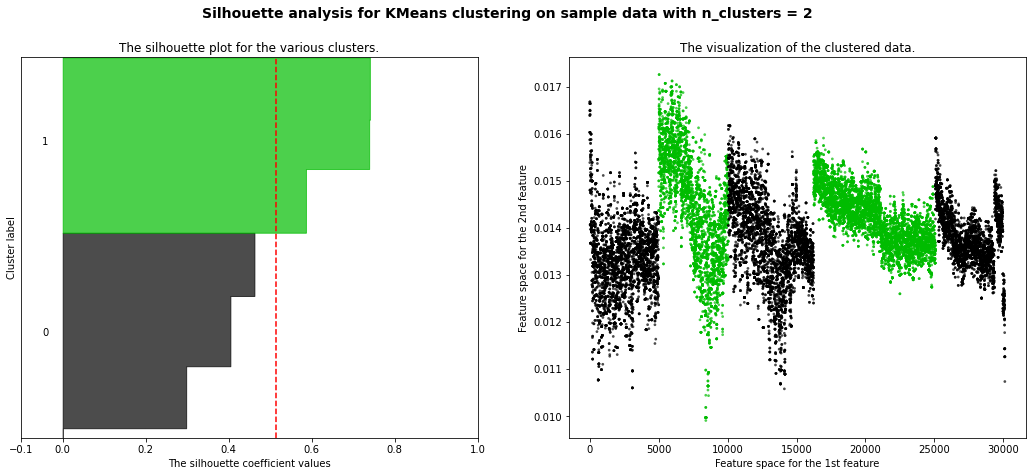

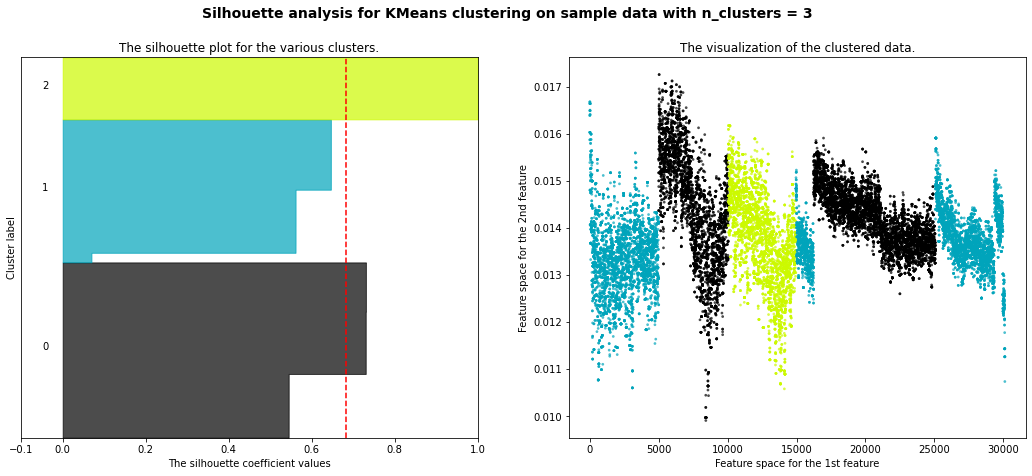

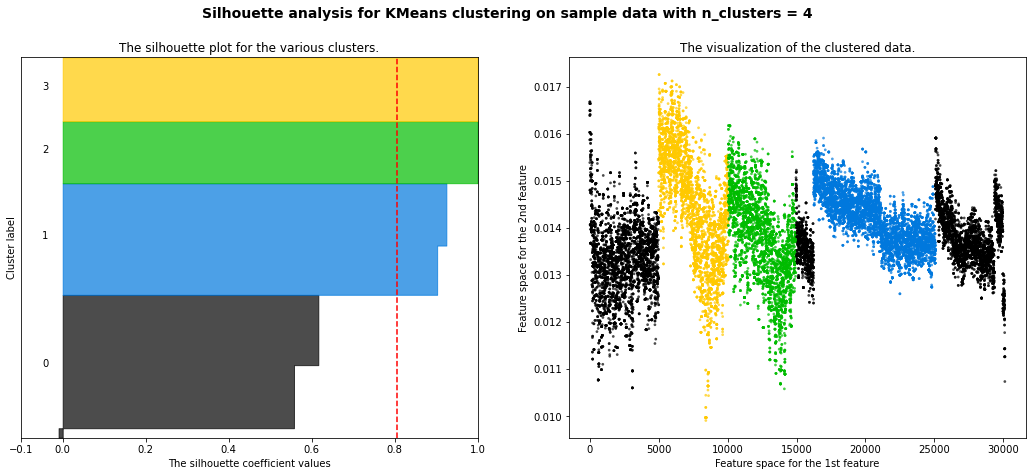

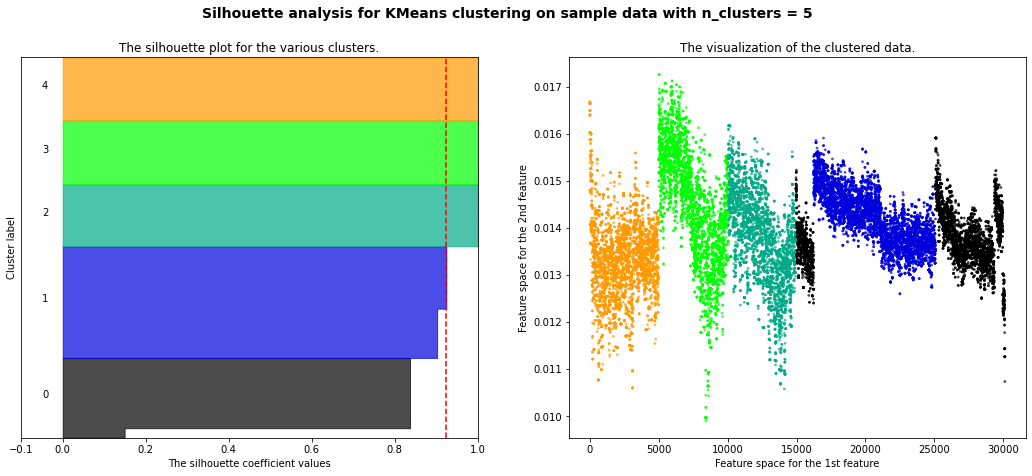

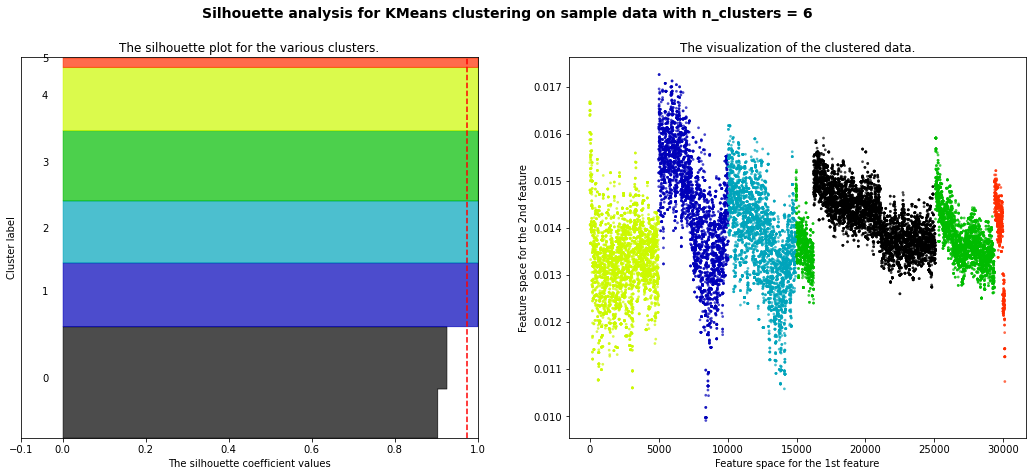

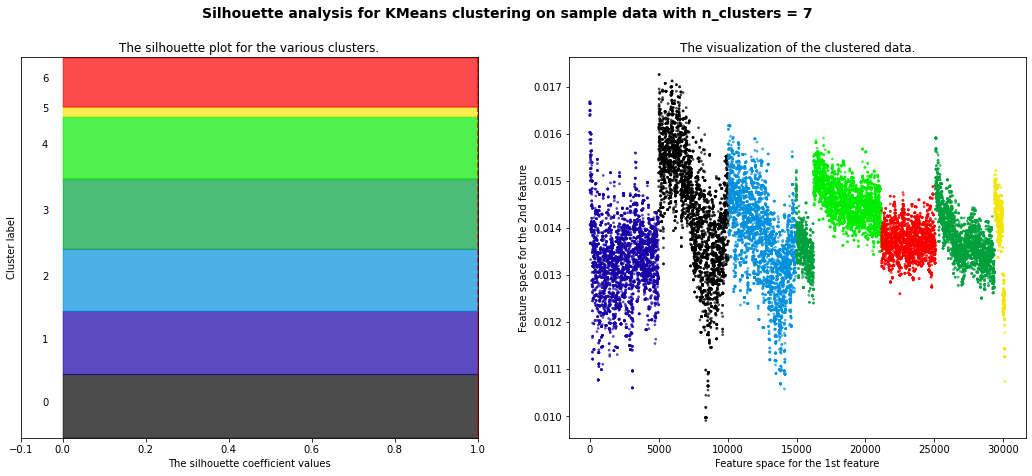

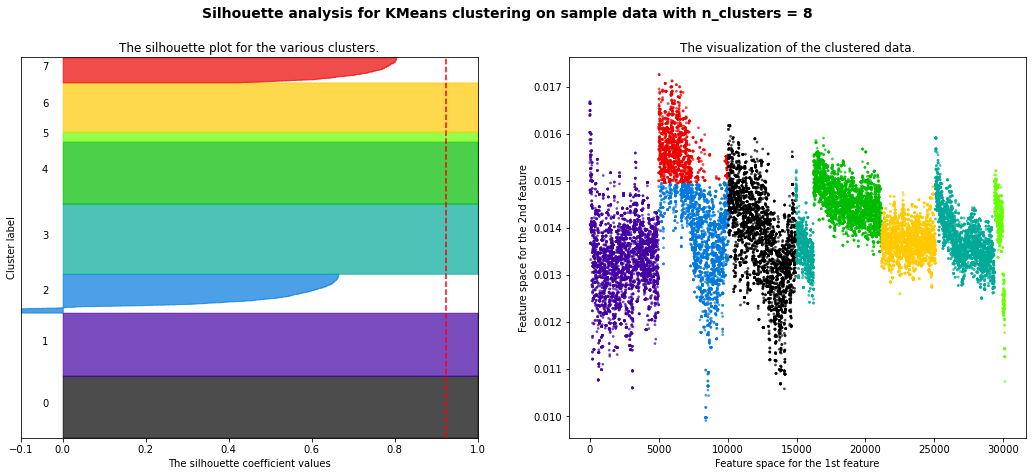

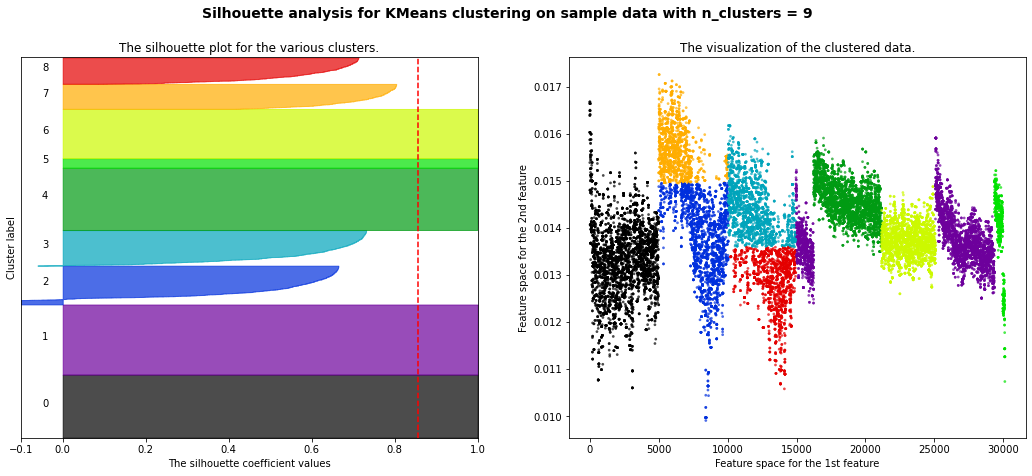

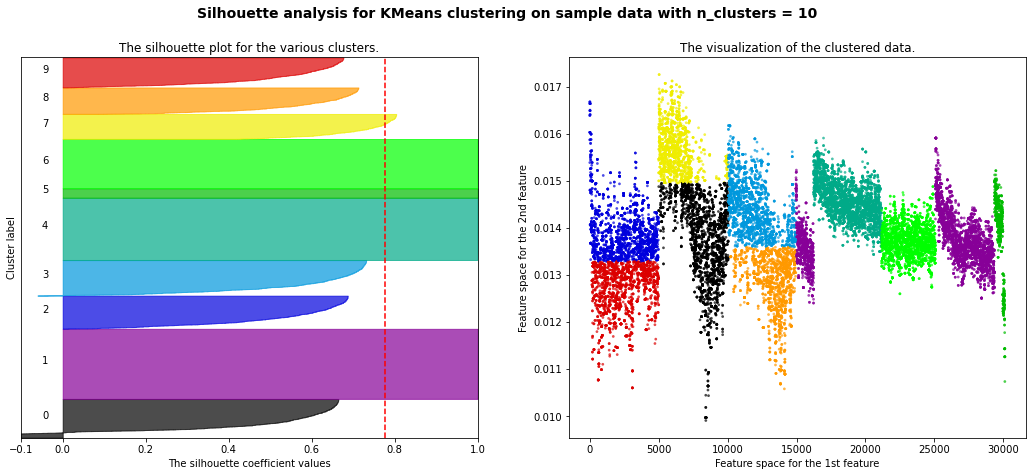

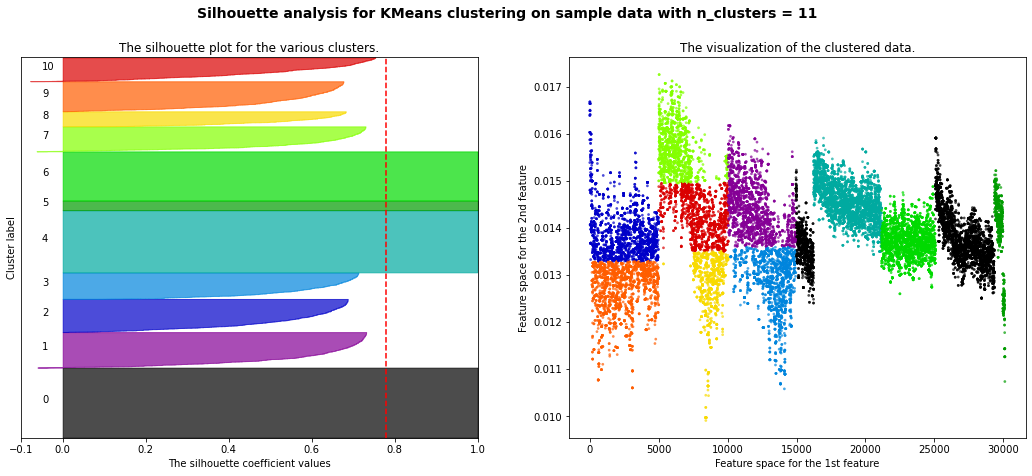

In [57]:
# Combine all trials into one DF
domingo_overall_cb = pd.concat([CB_RMS_OVERALL_B1, CB_RMS_OVERALL_B2, CB_RMS_OVERALL_B3,
                           CB_RMS_OVERALL_A1, CB_RMS_OVERALL_A2, CB_RMS_OVERALL_A3, CB_RMS_OVERALL_A4, CB_RMS_OVERALL_A5])
domingo_overall_cb = domingo_overall_cb.rename(columns={'Value': 'FFT'})
domingo_overall_cb = domingo_overall_cb.reset_index(drop=True)
display(domingo_overall_cb)

controlled_rms_cluster_df = domingo_overall_cb.drop(columns=['Time'])
controlled_rms_cluster_df = pd.get_dummies(controlled_rms_cluster_df)
controlled_rms_cluster_df['stiffener kit'] = controlled_rms_cluster_df['stiffener kit'].astype(int)
display(controlled_rms_cluster_df.head())

controlled_rms_cluster_data = controlled_rms_cluster_df.to_numpy()

# Normalize RMS and pressure
controlled_rms_cluster_data[:, :2] = min_max_norm(controlled_rms_cluster_data[:, :2])
print(controlled_rms_cluster_data)

# Perform clustering
controlled_rms_best_clustering = silhouette_cluster_analysis(controlled_rms_cluster_data, controlled_rms_cluster_df)

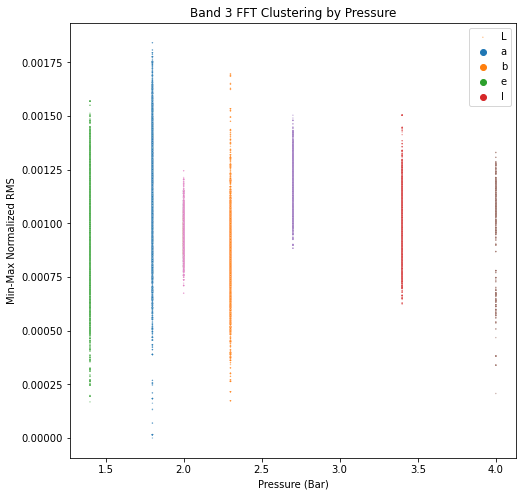

In [63]:
# FFT vs Pressure
figure(figsize=(8,8))
sns.scatterplot(x=controlled_rms_cluster_df.pressure, y=controlled_rms_cluster_data[:, 0], s=2, alpha=.5,
                hue=controlled_rms_best_clustering.labels_,
                palette=sns.color_palette( n_colors=len(np.unique(controlled_rms_best_clustering.labels_))) )
plt.title('Band 3 FFT Clustering by Pressure')
plt.xlabel('Pressure (Bar)')
plt.ylabel('Min-Max Normalized RMS')
plt.legend('Label')
plt.show()

[0.99999837]


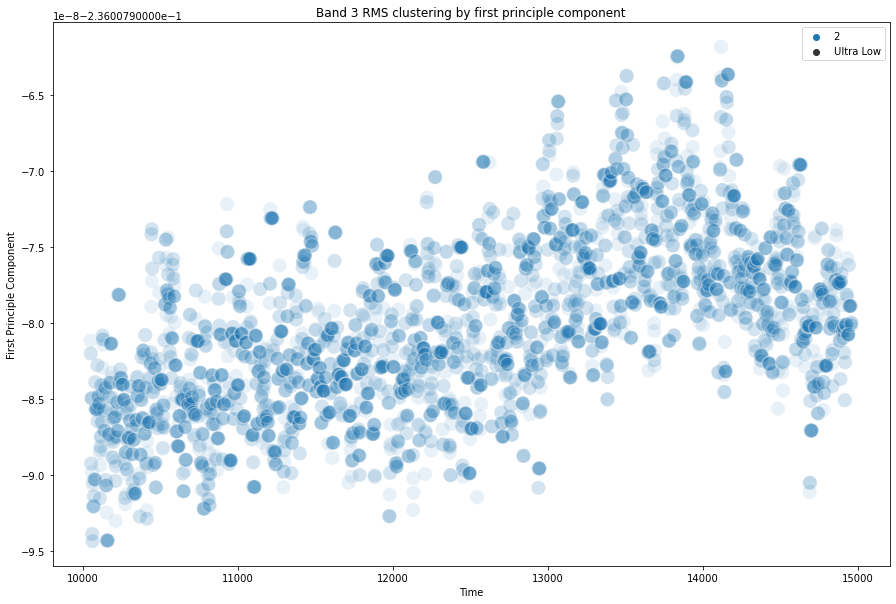

In [102]:
# PCA visualization
from sklearn.decomposition import PCA
# display(controlled_rms_cluster_df.head())
# display(domingo_overall_cb.head())
# print(controlled_rms_cluster_data)

pca = PCA(n_components=1)
first_pc = pca.fit_transform(controlled_rms_cluster_data[:, :2]).reshape(-1)
# print(first_pc)
print(pca.explained_variance_ratio_)

figure(figsize=(15,10))
start, end = 10050, 14960
sns.scatterplot(x=controlled_rms_cluster_df.index[start:end],
                y=first_pc[start:end],
                hue=controlled_rms_best_clustering.labels_[start:end],
                style=domingo_overall_cb.condition.iloc[start:end],
                palette=sns.color_palette( n_colors=len(np.unique(controlled_rms_best_clustering.labels_[start:end]))),
                s=200, alpha=.1)
plt.title('Controlled RMS clustering by first principle component')
plt.xlabel('Time')
plt.ylabel('First Principle Component')
plt.legend()

In [14]:
# # EDA for september batch

# sep = pd.read_excel('data/september-batch/grafana_data_export_OCT104.xlsx')
# sep.dropna(inplace=True)
# sep['Time'] = pd.to_datetime(sep['Time'])
# sept_melt = pd.melt(sep, id_vars='Time', var_name='Band', value_name='FFT')
# # display(sept_melt[sept_melt['Band'] == 'CB FFT Band 0'])
# # display(sept_melt[sept_melt['Band'] == 'CB FFT Band 7'])
# sept_melt.info()

In [15]:
# # definitions for the axes
# left, width = 0.1, 0.65
# bottom, height = 0.1, 0.65
# spacing = 0.005

# rect_scatter = [left, bottom, width, height]
# rect_histy = [left + width + spacing, bottom, 0.1, height]

# y_ax_lim = (sept_melt['FFT'].min(), sept_melt['FFT'].max())

# def scatter_hist(x, y, rolling_avg, title='placeholder', xlabel='Time', ylabel='FFT',
#                  y_ax_lim=None, x_ax_lim=None):

#     # start with a square Figure
#     fig = plt.figure(figsize=(10, 6), dpi=100)

#     ax = fig.add_axes(rect_scatter)
#     ax_histy = fig.add_axes(rect_histy, sharey=ax)

#     # no labels
#     ax_histy.tick_params(axis="y", labelleft=False)

#     # the scatter plot:
#     ax.scatter(x, y, s=3, alpha=.4)

#     # the rolling mean
#     ax.plot(rolling_avg, linewidth=2, color='red', label='1-minute rolling mean')
#     ax.legend()
#     ax.set_title(title)
#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)

#     # now determine nice limits by hand:
#     binwidth = 0.01
#     xymax = max(np.max(x), np.max(y))
#     lim = (int(xymax/binwidth) + 1) * binwidth

#     bins = np.arange(-lim, lim + binwidth, binwidth)
#     ax_histy.hist(y, orientation='horizontal')

#     plt.ylim(y_ax_lim)

# for band_name in sept_melt['Band'].unique():
#     temp_df = sept_melt[sept_melt['Band'] == band_name].reset_index(drop=True)
#     temp_df['Rolling Average'] = temp_df['FFT'].rolling(5*20).mean()
#     scatter_hist( np.array(temp_df.index), np.array(temp_df['FFT']), np.array(temp_df['Rolling Average']), band_name )
#     plt.show()

In [16]:
# seconds = 60
# interval = 40

# for run_code in domingo_band3['Run Code'].unique():
#     temp_df = domingo_band3[domingo_band3['Run Code'] == run_code].reset_index(drop=True)
#     temp_df['Rolling Average'] = temp_df['FFT'].rolling(interval).mean()
#     print(temp_df)
#     scatter_hist( np.array(temp_df.index), 
#                   np.array(temp_df['FFT']), 
#                   np.array(temp_df['Rolling Average']), 
#                   'Band 3 Run Code ' + run_code)
#     plt.show()

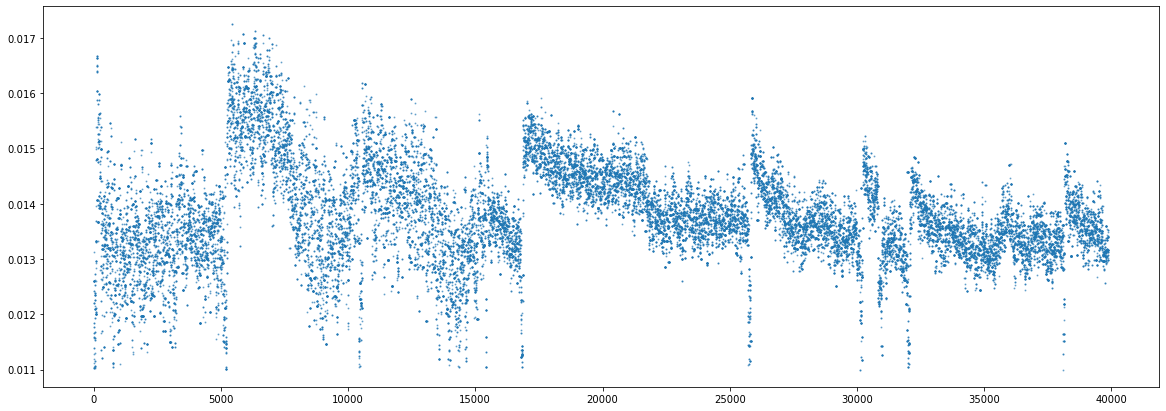

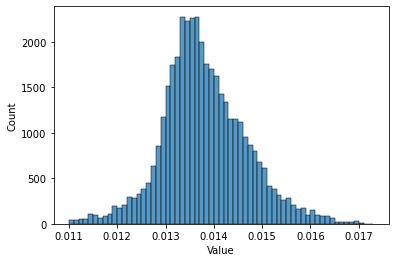

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display
import seaborn as sns

oct_overall = pd.read_csv('data/diego-controlled-runs/grafana_data_export oct_overall.csv', sep=';', engine='python', header=1)
oct_overall = oct_overall[oct_overall['Series'] == 'CB Bond Vibration'].reset_index(drop=True)
oct_overall_cb = oct_overall.drop(columns='Series')

df = oct_overall_cb.drop(np.arange(50000, 115000))
df = df.reset_index(drop=True)

df = df.drop(np.arange(97000, max(df.index)))
df = df.reset_index(drop=True)

df = df.drop(np.arange(32000, 40000))
df = df.reset_index(drop=True)

df = df[df['Value'] > 0.011]
df = df.reset_index(drop=True)

figure(figsize=(20,7))
plt.scatter(df.index, df.Value, s=1, alpha=.5)
plt.show()

sns.histplot(df.Value, binwidth=.0001)
plt.show()

C:\Users\camer\anaconda3\envs\general\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


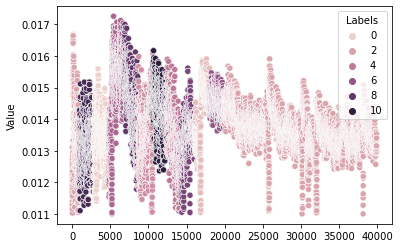

In [31]:
from sklearn.cluster import KMeans

data = np.array([df.index, df.Value])

clustering = KMeans(n_clusters=11).fit( data.reshape(data.shape[1],data.shape[0]) )
df['Labels'] = clustering.labels_
sns.scatterplot(df.index, df.Value, hue=df.Labels)
plt.show()

C:\Users\camer\anaconda3\envs\general\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


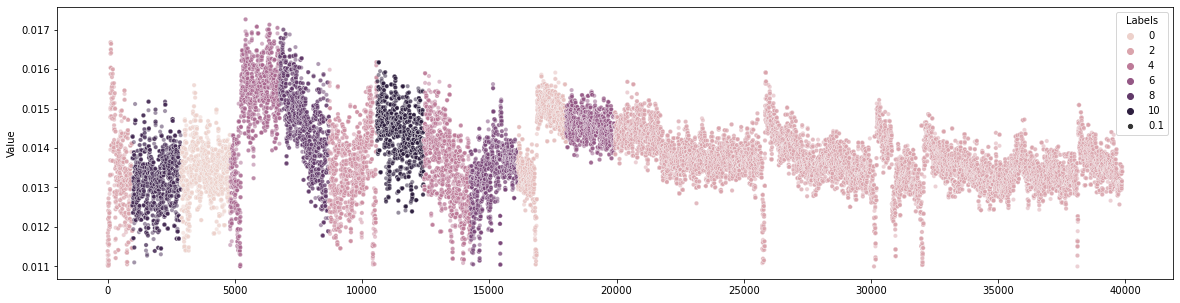

In [32]:
figure(figsize=(20,5))
sns.scatterplot(df.index, df.Value, hue=df.Labels, size=0.1, alpha=.5)
plt.show()